# Predict Bike Sharing Demand with AutoGluon Template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [2]:
#!pip install -U pip
#!pip install -U setuptools wheel
#!pip install -U "mxnet<2.0.0" bokeh==2.0.1
#!pip install autogluon --no-cache-dir
#!pip install kaggle
# Without --no-cache-dir, smaller aws instances may have trouble installing

### Setup Kaggle API Key

In [3]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "masinde"
kaggle_key = "26ba6a9b0bd0c324054f61b2158b9a7a"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

In [5]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [6]:
import pandas as pd
from autogluon.tabular import TabularPredictor  
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import numpy as np


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('train.csv', parse_dates=['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [9]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000


In [10]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv',  parse_dates=['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [11]:
# Same thing as train and test dataset
submission = pd.read_csv('sampleSubmission.csv')
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are predicting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [12]:
predictor = TabularPredictor(label="count", 
                             eval_metric='root_mean_squared_error',
                             problem_type='regression',
                             learner_kwargs={'ignored_columns': ['casual','registered']}
                            ).fit(train_data=train,
                                  time_limit=600,
                                  presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230106_094340/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230106_094340/"
AutoGluon Version:  0.6.1
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 26 20:36:53 UTC 2022
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    3111.6 MB
	Train Data (Original)  Memory Usage: 0.78 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.

### Review AutoGluon's training run with ranking of models that did the best.

In [13]:
predictor.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.891180      11.611984  494.836771                0.000705           0.319563            3       True         16
1   RandomForestMSE_BAG_L2  -53.445727      10.769307  400.381537                0.590471          25.229855            2       True         12
2     ExtraTreesMSE_BAG_L2  -53.917987      10.751853  382.799470                0.573016           7.647787            2       True         14
3          LightGBM_BAG_L2  -55.259432      10.400451  396.226219                0.221615          21.074536            2       True         11
4          CatBoost_BAG_L2  -55.751526      10.226176  440.565030                0.047340          65.413347            2       True         13
5        LightGBMXT_BAG_L2  -60.332825      13.353091  421.272341         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602

### Create predictions from test dataset

In [14]:
predictions = predictor.predict(test)
predictions.head()

0    22.057732
1    41.891243
2    46.129242
3    49.830822
4    52.967888
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [15]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.633026
std        90.410355
min         3.020617
25%        20.380463
50%        63.174416
75%       169.582840
max       365.678650
Name: count, dtype: float64

In [16]:
# How many negative values do we have?
predictions.lt(0).value_counts()

False    6493
Name: count, dtype: int64

In [17]:
# Set them to zero
predictions.iloc[predictions<0] = 0
predictions.lt(0).value_counts()

False    6493
Name: count, dtype: int64

### Set predictions to submission dataframe, save, and submit

In [18]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [19]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 345kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [20]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2023-01-06 09:54:30  first raw submission               complete  1.81208      1.81208       
submission.csv               2023-01-06 09:17:56  first raw submission               complete  1.80839      1.80839       
submission_new_hpo.csv       2023-01-06 08:58:29  new features with hyperparameters  complete  0.57913      0.57913       
submission_new_features.csv  2023-01-06 08:53:53  new features                       complete  0.47181      0.47181       


#### Initial score of 1.80370

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<AxesSubplot:title={'center':'datetime'}>,
        <AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>],
       [<AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'casual'}>,
        <AxesSubplot:title={'center':'registered'}>,
        <AxesSubplot:title={'center':'count'}>]], dtype=object)

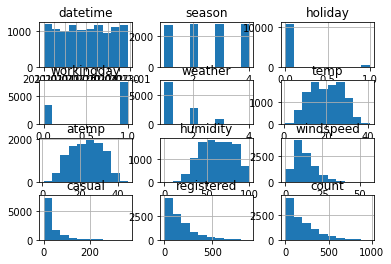

In [21]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist()

In [22]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [23]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000


##  Distributions of registered vs casual rides

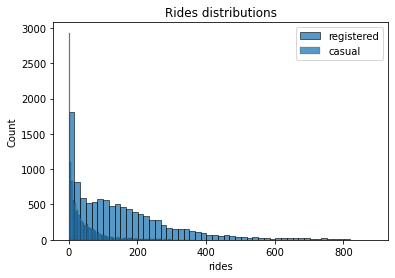

In [24]:
# plot distributions of registered vs casual rides
sns.histplot(train['registered'], label='registered')
sns.histplot(train['casual'], label='casual')
plt.legend()
plt.xlabel('rides')
plt.title("Rides distributions")
plt.savefig('rides_distributions.png', format='png')

The registered users perform way more rides than casual ones. Furthermore, we can see that the two distributions are skewed to the right, meaning that, for most of the entries in the data, zero or a small number of rides. Finally, every entry in the data has quite a large number of rides (that is, higher than 800).

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [25]:
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")

In [26]:
# create a new feature
train['year'] = train.datetime.dt.year
train['month'] = train.datetime.dt.month
train['day'] = train.datetime.dt.day
train['hour'] = train.datetime.dt.hour
train.drop(["datetime"], axis=1, inplace=True)

test['year'] = test.datetime.dt.year
test['month'] = test.datetime.dt.month
test['day'] = test.datetime.dt.day
test['hour'] = test.datetime.dt.hour
test.drop(["datetime"], axis=1, inplace=True)

In [27]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


[Text(0.5, 1.0, 'Count of bikes during working days: Registered users')]

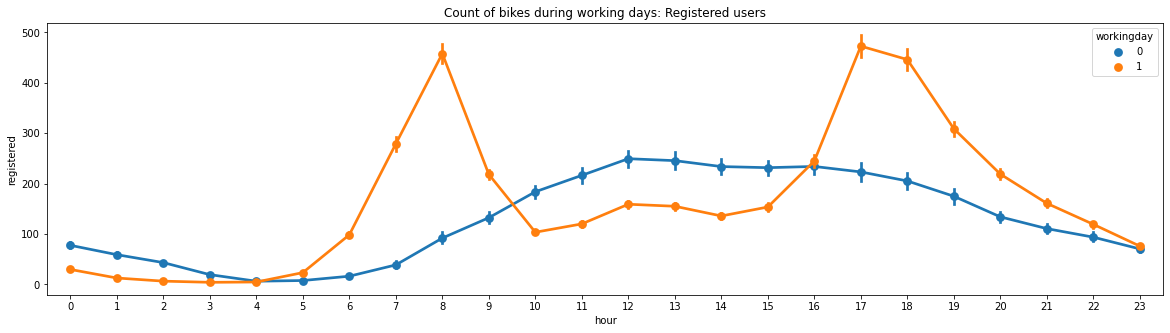

In [28]:
fig, ax = plt.subplots(figsize=(20,5))
sns.pointplot(data=train, x='hour', y='registered', hue='workingday', ax=ax)
ax.set(title='Count of bikes during working days: Registered users')

IndexError: index 3 is out of bounds for axis 0 with size 3

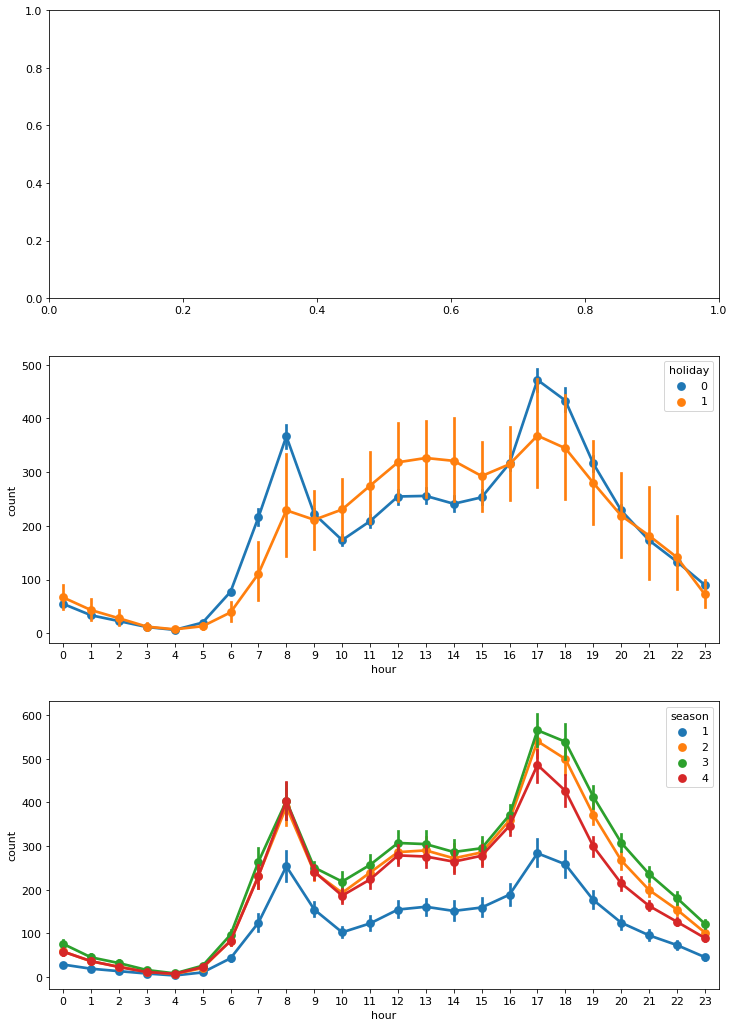

In [29]:
mpl.rc('font', size=11)
figure, axes = plt.subplots(nrows=3)
figure.set_size_inches(12,18)

sns.pointplot(x='hour', y='count', data=train, hue='holiday', ax=axes[1])
sns.pointplot(x='hour', y='count', data=train, hue='season', ax=axes[2])
sns.pointplot(x='hour', y='count', data=train, hue='weather', ax=axes[3])

The plots shows the busiest hours  or rush hours when the hire is high

In [ ]:
def plot_correlations(data, col):
    # get correlation between col and registered rides
    corr_r = np.corrcoef(data[col], data["registered"])[0,1]
    ax =sns.regplot(x=col, y='registered', data=data,scatter_kws={'alpha':0.05},label=f'Registered rides(correlation:{corr_r:.3f})')
    # get correlation between col and casual rides
    corr_c = np.corrcoef(data[col], data["casual"])[0,1]
    ax = sns.regplot(x=col, y='casual',data=data,scatter_kws={'alpha':0.05},label=f'Casual rides (correlation:{corr_c:.3f})')
    #adjust legend alpha
    legend = ax.legend()
    for lh in legend.legendHandles:
        lh.set_alpha(0.5)
    ax.set_ylabel("rides")
    ax.set_title(f"Correlation between rides and {col}")
    return ax

### Correlation between rides and temperature

In [ ]:
plt.figure(figsize=(10,8))
ax = plot_correlations(train, 'temp')
plt.savefig('correlation_temp.png', format='png')


In [ ]:
plt.figure(figsize=(10,8))
ax = plot_correlations(train, 'atemp')
plt.savefig('correlation_atemp.png', format='png')

The higher temperatures have a positive impact on the number of rides (the correlation between registered/casual rides and temp is 0.31 and 0.46, respectively, and it's a similar case for atemp). Note that as the values in the registered column are widely spread with respect to the different values in temp, we have a lower correlation compared to the casual column.

### Correlation between rides and humidity

In [ ]:
plt.figure(figsize=(10,8))
ax = plot_correlations(train, 'humidity')
plt.savefig('correlation_hum.png', format='png')


 The humidity level has a negative correlation with both types of rides (-0.265 for registered and -0.348 for casual). This means that with a high level of humidity (mist or rain), customers will tend not to use the bike sharing service.

### Correlation between the number of rides and the wind speed

In [ ]:
plt.figure(figsize=(10,8))
ax = plot_correlations(train, 'windspeed')
plt.savefig('correlation_windspeed.png', format='png')

There is minimal correlation between the number of rides and the wind speed .

## Correlation Matrix Plot
A comparison between different continuous features is  to use the correlation matrix plot. It allows us to quickly visualize any possible relationships between the different features and identify potential clusters with highly correlated features.

With the training data we will visualize the temperature, atemp, humidity, windspeed, registered and casual columns.

In [ ]:
# plot correlation matrix
cols = ["temp", "atemp", "humidity", "windspeed", "registered", "casual"]
plot_data = train[cols]
corr = plot_data.corr()
fig = plt.figure(figsize=(10,8))
plt.matshow(corr, fignum=fig.number)
plt.xticks(range(len(plot_data.columns)), plot_data.columns)
plt.yticks(range(len(plot_data.columns)), plot_data.columns)
plt.colorbar()
plt.ylim([5.5, -0.5])
fig.savefig('correlations.png', format='png')

##### The conclusion of the visualization is that when the temperature is good the hire of the bike is good for both registered users and casual users.

## Step 5: Rerun the model with the same settings as before, just with more features

In [ ]:
predictor_new_features = TabularPredictor(label="count", 
                             eval_metric='root_mean_squared_error',
                             problem_type='regression',
                             learner_kwargs={'ignored_columns': ['casual','registered']}
                            ).fit(train_data=train,
                                  time_limit=600,
                                  presets="best_quality"
)

In [ ]:
predictor_new_features.fit_summary()

In [ ]:
# Remember to set all negative values to zero
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features.iloc[predictions_new_features.lt(0)] = 0

predictions_new_features.head()

In [ ]:
# Same submitting predictions
submission_new_features = pd.read_csv('sampleSubmission.csv', parse_dates=["datetime"])
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

#### New Score of 0.47052


## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [ ]:
num_trials = 5
search_strategy = 'auto'
hyperparameters = {
  'NN_TORCH': {'num_epochs': 10, 'batch_size': 32}, 
  'GBM': {'num_boost_round': 20}
}
hyperparameter_tune_kwargs = { 
  'num_trials': num_trials,
  'scheduler' : 'local',
  'searcher': search_strategy,
}


predictor_new_hpo = TabularPredictor(label="count", 
                             eval_metric='root_mean_squared_error',
                             problem_type='regression',
                             learner_kwargs={'ignored_columns': ['casual','registered']}
                            ).fit(train_data=train,
                                  num_bag_folds=5,
                                  num_bag_sets=1,
                                  num_stack_levels=1,
                                  time_limit=600,
                                  presets="best_quality",
                                  hyperparameters=hyperparameters,
                                  hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
)

In [ ]:
predictor_new_hpo.fit_summary()

In [ ]:
# Remember to set all negative values to zero
predictions_new_hpo = predictor_new_hpo.predict(test)
predictions_new_hpo.iloc[predictions_new_hpo.lt(0)] = 0

In [ ]:
# Same submitting predictions
submission_new_hpo = pd.read_csv('sampleSubmission.csv', parse_dates=["datetime"])
submission_new_hpo["count"] = predictions_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

#### New Score of 0.53050

### Hyperparameter table

In [ ]:
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [
            predictor.leaderboard(silent=True)['score_val'][0],
            predictor_new_features.leaderboard(silent=True)['score_val'][0],
            predictor_new_hpo.leaderboard(silent=True)['score_val'][0]
        ]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('img/model_train_score.png')

In [ ]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [
            predictor.leaderboard(silent=True)['score_val'][0],
            predictor_new_features.leaderboard(silent=True)['score_val'][0],
            predictor_new_hpo.leaderboard(silent=True)['score_val'][0]
        ]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('img/model_test_score.png')

In [ ]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "score": [
            predictor.leaderboard(silent=True)['score_val'][0],
            predictor_new_features.leaderboard(silent=True)['score_val'][0],
            predictor_new_hpo.leaderboard(silent=True)['score_val'][0]
        ]
    
})